In [ ]:
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.layers import TimeDistributed, GlobalAveragePooling1D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, AveragePooling1D
from keras.layers import Embedding
from keras.layers import Dropout, Flatten, Bidirectional, Dense, Activation, TimeDistributed
from keras.models import Model, Sequential
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from string import ascii_lowercase
from collections import Counter
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models import doc2vec
from gensim.models import KeyedVectors
import itertools, nltk, snowballstemmer, re

LabeledSentence = doc2vec.LabeledSentence

In [ ]:
class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        flipped = {}
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Deep Learning/yelp_review_polarity_csv/train.csv", names = ["label", 'text'])

In [ ]:
data.head()

,label,text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [ ]:
df = data.sample(frac=1)

In [ ]:
df.head()

,label,text
252689,2,"I love this trail, it's especially good for ea..."
149400,2,This is my second time coming here for lunch a...
202606,1,"The gym itself is wonderful, I was a member be..."
148537,2,I've been to the original Bouchon in Yountvill...
528104,2,21 different burgers with a variety of protein...


In [ ]:
df = df[:10000]

In [ ]:
df.describe()

,label
count,560000.0
mean,1.5
std,0.5
min,1.0
25%,1.0
50%,1.5
75%,2.0
max,2.0


In [ ]:
def create_class(c):
    if c['polarity'] == 1 and c['deceptive'] == 1:
        return [1,1]
    elif c['polarity'] == 1 and c['deceptive'] == 0:
        return [1,0]
    elif c['polarity'] == 0 and c['deceptive'] == 1:
        return [0,1]
    else:
        return [0,0]
    
def specific_class(c):
    if c['polarity'] == 1 and c['deceptive'] == 1:
        return "TRUE_POSITIVE"
    elif c['polarity'] == 1 and c['deceptive'] == 0:
        return "FALSE_POSITIVE"
    elif c['polarity'] == 0 and c['deceptive'] == 1:
        return "TRUE_NEGATIVE"
    else:
        return "FALSE_NEGATIVE"

data['final_class'] = data.apply(create_class, axis=1)
data['given_class'] = data.apply(specific_class, axis=1)

In [ ]:
data['final_class']

0       [1, 1]
1       [1, 1]
2       [1, 1]
3       [1, 1]
4       [1, 1]
         ...  
1595    [0, 0]
1596    [0, 0]
1597    [0, 0]
1598    [0, 0]
1599    [0, 0]
Name: final_class, Length: 1600, dtype: object

In [ ]:
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",TRUE_POSITIVE
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",TRUE_POSITIVE
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",TRUE_POSITIVE
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",TRUE_POSITIVE
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",TRUE_POSITIVE


In [ ]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
# Encode labels in column 'species'. 
data['given_class']= label_encoder.fit_transform(data['given_class']) 

In [ ]:
data['given_class'].unique()

array([3, 1, 2, 0])

In [ ]:
Y = data['given_class']
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
dummy_y = np_utils.to_categorical(encoded_Y)

In [ ]:
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",3
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",3
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",3
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",3
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",3


In [ ]:
textData = pd.DataFrame(list(data['text'])) 

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# stemmer
stemmer = snowballstemmer.EnglishStemmer()

#stopword list
stop = stopwords.words('english')
stop.extend(['may','also','zero','one','two','three','four','five','six','seven','eight','nine','ten','across','among','beside','however','yet','within']+list(ascii_lowercase))
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist))) 

In [ ]:
textData[0].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ',inplace=True,regex=True)
wordlist = filter(None, " ".join(list(set(list(itertools.chain(*textData[0].str.split(' ')))))).split(" "))
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in textData[0].str.lower().str.split(' ')]

In [ ]:
minimum_count = 1
str_frequencies = pd.DataFrame(list(Counter(filter(None,list(itertools.chain(*data['stemmed_text_data'].str.split(' '))))).items()),columns=['word','count'])
low_frequency_words = set(str_frequencies[str_frequencies['count'] < minimum_count]['word'])
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in low_frequency_words, line))) for line in data['stemmed_text_data'].str.split(' ')]
data['stemmed_text_data'] = [" ".join(stemmer.stemWords(re.sub('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ', next_text).split(' '))) for next_text in data['stemmed_text_data']]    

In [ ]:
lmtzr = WordNetLemmatizer()
w = re.compile("\w+",re.I)

def label_sentences(df, input_point):
    labeled_sentences = []
    list_sen = []
    for index, datapoint in df.iterrows():
        tokenized_words = re.findall(w,datapoint[input_point].lower())
        labeled_sentences.append(LabeledSentence(words=tokenized_words, tags=['SENT_%s' %index]))
        list_sen.append(tokenized_words)
    return labeled_sentences, list_sen

def train_doc2vec_model(labeled_sentences):
    model = Doc2Vec(min_count=1, window=9, size=512, sample=1e-4, negative=5, workers=7)
    model.build_vocab(labeled_sentences)
    pretrained_weights = model.wv.syn0
    vocab_size, embedding_size = pretrained_weights.shape
    model.train(labeled_sentences, total_examples=vocab_size, epochs=400)
    
    return model

In [ ]:
textData = data['stemmed_text_data'].to_frame().reset_index()
sen, corpus = label_sentences(textData, 'stemmed_text_data')

<ipython-input-22-1453ad03773f>:9: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  labeled_sentences.append(LabeledSentence(words=tokenized_words, tags=['SENT_%s' %index]))


In [ ]:
doc2vec_model = train_doc2vec_model(sen)

/usr/local/lib/python3.8/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
<ipython-input-22-1453ad03773f>:16: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  pretrained_weights = model.wv.syn0


In [ ]:
doc2vec_model.save("doc2vec_model_opinion_corpus.d2v")

In [ ]:
doc2vec_model = Doc2Vec.load("doc2vec_model_opinion_corpus.d2v") 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

tfidf1 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,1))
result_train1 = tfidf1.fit_transform(corpus)

tfidf2 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,2))
result_train2 = tfidf2.fit_transform(corpus)

tfidf3 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,3))
result_train3 = tfidf3.fit_transform(corpus)

svd = TruncatedSVD(n_components=512, n_iter=40, random_state=34)
tfidf_data1 = svd.fit_transform(result_train1)
tfidf_data2 = svd.fit_transform(result_train2)
tfidf_data3 = svd.fit_transform(result_train3)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy

nlp = spacy.load('en_core_web_sm')
temp_textData = pd.DataFrame(list(data['text']))

overall_pos_tags_tokens = []
overall_pos = []
overall_tokens = []
overall_dep = []

for i in range(1600):
    doc = nlp(temp_textData[0][i])
    given_pos_tags_tokens = []
    given_pos = []
    given_tokens = []
    given_dep = []
    for token in doc:
        output = "%s_%s" % (token.pos_, token.tag_)
        given_pos_tags_tokens.append(output)
        given_pos.append(token.pos_)
        given_tokens.append(token.tag_)
        given_dep.append(token.dep_)
        
    overall_pos_tags_tokens.append(given_pos_tags_tokens)
    overall_pos.append(given_pos)
    overall_tokens.append(given_tokens)
    overall_dep.append(given_dep)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
from sklearn.preprocessing import MinMaxScaler

count = CountVectorizer(tokenizer=lambda i:i, lowercase=False)
pos_tags_data = count.fit_transform(overall_pos_tags_tokens).todense()
pos_data = count.fit_transform(overall_pos).todense()
tokens_data = count.fit_transform(overall_tokens).todense()
dep_data = count.fit_transform(overall_dep).todense()
min_max_scaler = MinMaxScaler()
normalized_pos_tags_data = min_max_scaler.fit_transform(pos_tags_data)
normalized_pos_data = min_max_scaler.fit_transform(pos_data)
normalized_tokens_data = min_max_scaler.fit_transform(tokens_data)
normalized_dep_data = min_max_scaler.fit_transform(dep_data)

final_pos_tags_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_pos_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_tokens_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_dep_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_pos_tags_data[:normalized_pos_tags_data.shape[0],:normalized_pos_tags_data.shape[1]] = normalized_pos_tags_data
final_pos_data[:normalized_pos_data.shape[0],:normalized_pos_data.shape[1]] = normalized_pos_data
final_tokens_data[:normalized_tokens_data.shape[0],:normalized_tokens_data.shape[1]] = normalized_tokens_data
final_dep_data[:normalized_dep_data.shape[0],:normalized_dep_data.shape[1]] = normalized_dep_data

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn

In [ ]:
maxlength = []
for i in range(0,len(sen)):
    maxlength.append(len(sen[i][0]))
print(max(maxlength))   

370


In [ ]:
def vectorize_comments(df,d2v_model):
    y = []
    comments = []
    for i in range(0,df.shape[0]):
        label = 'SENT_%s' %i
        comments.append(d2v_model.docvecs[label])
    df['vectorized_comments'] = comments
    
    return df

textData = vectorize_comments(textData,doc2vec_model)
print (textData.head(2))

   index                                  stemmed_text_data  \
0      0  stay night getaway famili thursday tripl aaa r...   
1      1  tripl rate upgrad view room less $ includ brea...   

                                 vectorized_comments  
0  [-0.28982332, 0.48595628, 0.020498738, -0.4886...  
1  [0.006588426, 0.28767073, -0.26128858, -0.1097...  


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,GridSearchCV 

X_train, X_test, y_train, y_test = train_test_split(textData["vectorized_comments"].T.tolist(), dummy_y, test_size=0.1, random_state=56)

In [ ]:
X = np.array(textData["vectorized_comments"].T.tolist()).reshape((1,1600,512))
y = np.array(dummy_y).reshape((1600,4))
X_train2 = np.array(X_train).reshape((1,1440,512))
y_train2 = np.array(y_train).reshape((1,1440,4))
X_test2 = np.array(X_test).reshape((1,160,512))
y_test2 = np.array(y_test).reshape((1,160,4))

In [ ]:
from sklearn.model_selection import StratifiedKFold
Xtemp = textData["vectorized_comments"].T.tolist()
ytemp = data['given_class']
training_indices = []
testing_indices = []

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(Xtemp, ytemp)

for train_index, test_index in skf.split(Xtemp, ytemp):
    training_indices.append(train_index)
    testing_indices.append(test_index)

In [ ]:
def extractTrainingAndTestingData(givenIndex):
    X_train3 = np.zeros(shape=(1440, max(maxlength)+10, 512)).astype(np.float32)
    Y_train3 = np.zeros(shape=(1440, 4)).astype(np.float32)
    X_test3 = np.zeros(shape=(160, max(maxlength)+10, 512)).astype(np.float32)
    Y_test3 = np.zeros(shape=(160, 4)).astype(np.float32)

    empty_word = np.zeros(512).astype(np.float32)

    count_i = 0
    for i in training_indices[givenIndex]:
        len1 = len(sen[i][0])
        average_vector1 = np.zeros(512).astype(np.float32)
        average_vector2 = np.zeros(512).astype(np.float32)
        average_vector3 = np.zeros(512).astype(np.float32)
        for j in range(max(maxlength)+10):
            if j < len1:
                X_train3[count_i,j,:] = doc2vec_model[sen[i][0][j]]
                average_vector1 += result_train1[i, tfidf1.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector2 += result_train2[i, tfidf2.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector3 += result_train3[i, tfidf3.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
            elif j == len1:
                X_train3[count_i,j,:] = tfidf_data1[i]
            elif j == len1 + 1:
                X_train3[count_i,j,:] = tfidf_data2[i]
            elif j == len1+2:
                X_train3[count_i,j,:] = tfidf_data3[i]
            elif j == len1+3:
                X_train3[count_i,j,:] = average_vector1
            elif j == len1+4:
                X_train3[count_i,j,:] = average_vector2
            elif j == len1+5:
                X_train3[count_i,j,:] = average_vector3
            elif j == len1+6:
                X_train3[count_i,j,:] = final_pos_tags_data[i] 
            elif j == len1+7:
                X_train3[count_i,j,:] = final_pos_data[i]
            elif j == len1+8:
                X_train3[count_i,j,:] = final_tokens_data[i]
            elif j == len1+9:
                X_train3[count_i,j,:] = final_dep_data[i]
            else:
                X_train3[count_i,j,:] = empty_word

        Y_train3[count_i,:] = dummy_y[i]
        count_i += 1

    count_i = 0
    for i in testing_indices[givenIndex]:
        len1 = len(sen[i][0])
        average_vector1 = np.zeros(512).astype(np.float32)
        average_vector2 = np.zeros(512).astype(np.float32)
        average_vector3 = np.zeros(512).astype(np.float32)
        for j in range(max(maxlength)+10):
            if j < len1:
                X_test3[count_i,j,:] = doc2vec_model[sen[i][0][j]]
                average_vector1 += result_train1[i, tfidf1.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector2 += result_train2[i, tfidf2.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]  
                average_vector3 += result_train3[i, tfidf3.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
            elif j == len1:
                X_test3[count_i,j,:] = tfidf_data1[i]
            elif j == len1 + 1:
                X_test3[count_i,j,:] = tfidf_data2[i]
            elif j == len1+2:
                X_test3[count_i,j,:] = tfidf_data3[i]
            elif j == len1+3:
                X_test3[count_i,j,:] = average_vector1
            elif j == len1+4:
                X_test3[count_i,j,:] = average_vector2
            elif j == len1+5:
                X_test3[count_i,j,:] = average_vector3
            elif j == len1+6:
                X_test3[count_i,j,:] = final_pos_tags_data[i]
            elif j == len1+7:
                X_test3[count_i,j,:] = final_pos_data[i]
            elif j == len1+8:
                X_test3[count_i,j,:] = final_tokens_data[i]
            elif j == len1+9:
                X_test3[count_i,j,:] = final_dep_data[i]
            else:
                X_test3[count_i,j,:] = empty_word

        Y_test3[count_i,:] = dummy_y[i]
        count_i += 1
        
    return X_train3, X_test3, Y_train3, Y_test3

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=9, padding='same', activation='relu', input_shape=(max(maxlength)+10,512)))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=7, padding='same', activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(50, dropout=0.25, recurrent_dropout=0.2)))
model.add(Dense(4, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 380, 128)          589952    
                                                                 
 dropout (Dropout)           (None, 380, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 190, 128)         0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 190, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 190, 128)          114816    
                                                                 
 dropout_2 (Dropout)         (None, 190, 128)          0         
                                                        

In [ ]:
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint 

final_accuracies = []
    
filename = 'weights.best.from_scratch%s.hdf5' % 9
checkpointer = ModelCheckpoint(filepath=filename, verbose=1, save_best_only=True)
X_train3, X_test3, Y_train3, Y_test3 = extractTrainingAndTestingData(9)

In [ ]:
history = model.fit(X_train3, Y_train3, epochs=15, batch_size=512, callbacks=[checkpointer], validation_data=(X_test3, Y_test3), verbose=1)

Epoch 1/15
3/3 [==============================] - ETA: 0s - loss: 0.6144 - accuracy: 0.2458 
Epoch 1: val_loss improved from inf to 0.56167, saving model to weights.best.from_scratch9.hdf5
3/3 [==============================] - 49s 14s/step - loss: 0.6144 - accuracy: 0.2458 - val_loss: 0.5617 - val_accuracy: 0.2500
Epoch 2/15
3/3 [==============================] - ETA: 0s - loss: 0.5610 - accuracy: 0.2910 
Epoch 2: val_loss improved from 0.56167 to 0.53924, saving model to weights.best.from_scratch9.hdf5
3/3 [==============================] - 41s 14s/step - loss: 0.5610 - accuracy: 0.2910 - val_loss: 0.5392 - val_accuracy: 0.5375
Epoch 3/15
3/3 [==============================] - ETA: 0s - loss: 0.5435 - accuracy: 0.3667 
Epoch 3: val_loss improved from 0.53924 to 0.50343, saving model to weights.best.from_scratch9.hdf5
3/3 [==============================] - 43s 14s/step - loss: 0.5435 - accuracy: 0.3667 - val_loss: 0.5034 - val_accuracy: 0.4875
Epoch 4/15
3/3 [=========================

In [ ]:
model.evaluate(X_test3, Y_test3)

5/5 [==============================] - 2s 327ms/step - loss: 0.2493 - accuracy: 0.8062


[0.2492770254611969, 0.8062499761581421]

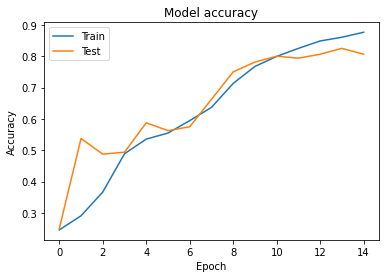

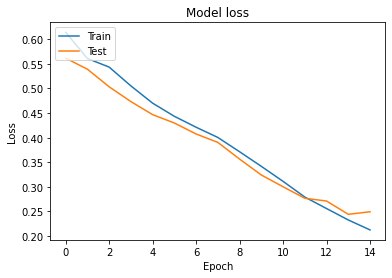

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validasi accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validasi loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights(filename)

In [ ]:
for i in range(3):
  filename = 'weights.best.from_scratch%s.hdf5' % i
  checkpointer = ModelCheckpoint(filepath=filename, verbose=1, save_best_only=True)
  X_train3, X_test3, Y_train3, Y_test3 = extractTrainingAndTestingData(i)
  model.fit(X_train3, Y_train3, epochs=10, batch_size=512, callbacks=[checkpointer], validation_data=(X_test3, Y_test3))
  model.load_weights(filename)
  predicted = np.rint(model.predict(X_test3))
  final_accuracies.append(accuracy_score(Y_test3, predicted))
  print(accuracy_score(Y_test3, predicted))

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.8674 
Epoch 1: val_loss improved from inf to 0.20404, saving model to weights.best.from_scratch0.hdf5
3/3 [==============================] - 44s 14s/step - loss: 0.2150 - accuracy: 0.8674 - val_loss: 0.2040 - val_accuracy: 0.8750
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.8917 
Epoch 2: val_loss improved from 0.20404 to 0.19200, saving model to weights.best.from_scratch0.hdf5
3/3 [==============================] - 43s 14s/step - loss: 0.1942 - accuracy: 0.8917 - val_loss: 0.1920 - val_accuracy: 0.8875
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9028 
Epoch 3: val_loss improved from 0.19200 to 0.18729, saving model to weights.best.from_scratch0.hdf5
3/3 [==============================] - 42s 14s/step - loss: 0.1772 - accuracy: 0.9028 - val_loss: 0.1873 - val_accuracy: 0.8938
Epoch 4/10
3/3 [=========================

In [ ]:
print(sum(final_accuracies) / len(final_accuracies))

0.9541666666666666
